### Helper Functions and imports

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from scipy.optimize import minimize

In [2]:
def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

In [3]:
def normalize_grid(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [4]:
def objective(x):
    a = int(x[0])
    b = int(x[1])
    return float(s_grid_values[a, b] + p_grid_values[a, b] + d_grid_values[a, b])

In [5]:
def get_grids_percent(e_grid_values, grid_values):
    return np.sum(e_grid_values) / np.sum(grid_values)

### Load Data

In [6]:
s_grid_file = open('non_zero Насыщенность', 'r')
p_grid_file = open('non_zero Пористость', 'r')
d_grid_file = open('non_zero Толщины', 'r')

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 333504.97it/s]


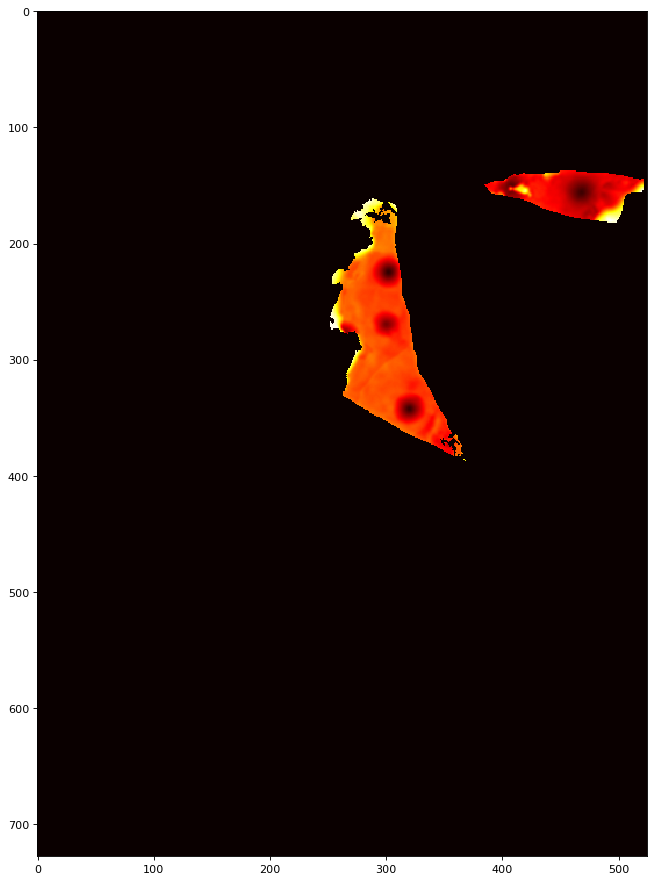

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 330056.16it/s]


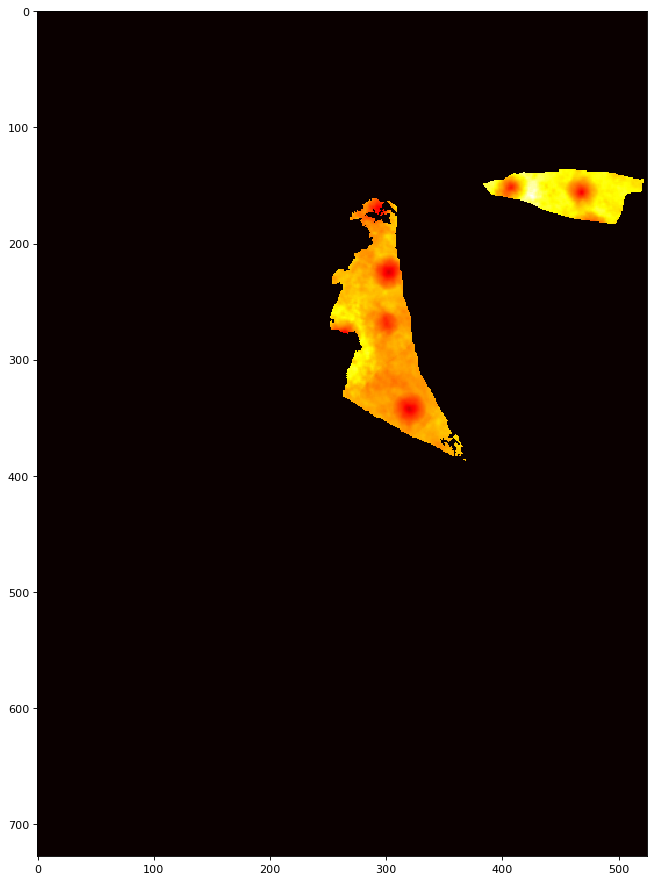

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 255904.32it/s]


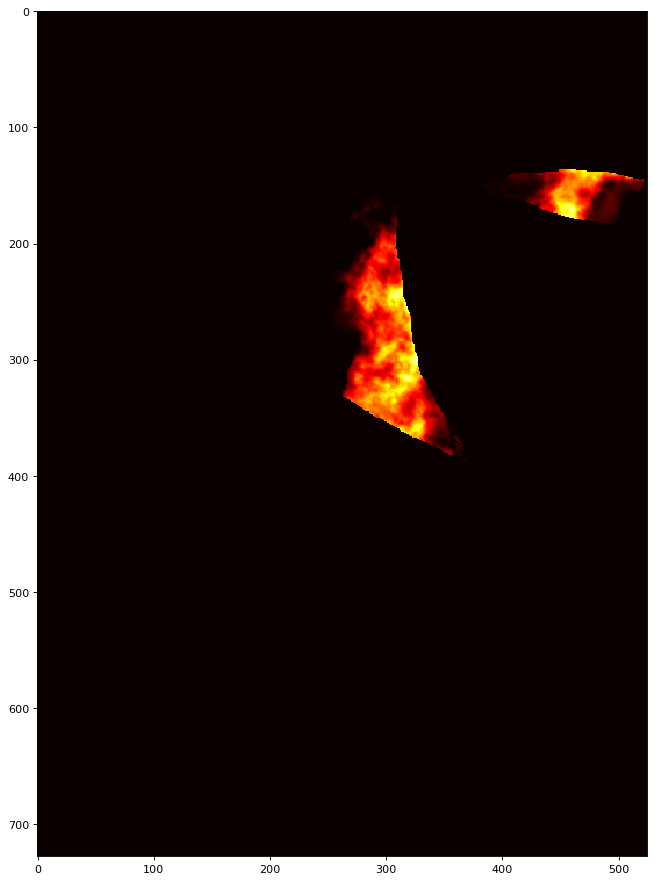

In [7]:
grids = []
for grid_file in [s_grid_file, p_grid_file, d_grid_file]:
    lines = grid_file.readlines()
    for i in range (0, len(lines)):
        lines[i] = lines[i].replace('\n', '')
    
    numX = int(lines[0].split(' ')[1])
    numY = int(lines[2].split(' ')[0])
    b_lines = lines[4:]
    print('x size:', numX)
    print('y size:', numY)
    len(b_lines) * 6 == numX*numY
    
    grid_values = np.zeros((numX, numY)) 
    x_i = 0
    y_i = 0

    for l in tqdm(b_lines):
        values = l.split(' ')
        for val in values:
            if int(float(val)) != 9999900:
                grid_values[x_i][y_i] = float(val)

            y_i += 1
            if y_i == numY:
                y_i = 0
                x_i += 1
    
    grid_values = np.fliplr(grid_values[::-1,::-1])
    figure(figsize=(16, 14), dpi=80)
    plt.imshow(grid_values, cmap='hot', interpolation='none')
    plt.show()
    grids.append(grid_values)

In [8]:
s_grid_values = grids[0]
p_grid_values = grids[1]
d_grid_values = grids[2]

print(s_grid_values.shape == p_grid_values.shape)
print(s_grid_values.shape == d_grid_values.shape)

True
True


### Parameters set

In [45]:
r = 5. # radius
b_percent = 0.0 # percent threshold (in %)

### Robust algorithm

In [46]:
x = np.arange(0, numX)
y = np.arange(0, numY)

In [47]:
robust_min_std = 3
robust_well_coords = (0, 0)
max_robust_percentage = 0

p_flag = True
all_ok = False

s_optimized_grid_values = s_grid_values
p_optimized_grid_values = p_grid_values
d_optimized_grid_values = d_grid_values

for i in tqdm(range(0, len(s_grid_values))):
    for j in range(0, len(s_grid_values[i])):
        if s_grid_values[i][j] == 0.0 and p_grid_values[i][j] == 0.0 and d_grid_values[i][j] == 0.0:
            continue
        
        c_s_grid_values = s_grid_values.copy()
        c_p_grid_values = p_grid_values.copy()
        c_d_grid_values = d_grid_values.copy()
        
        cx = float(j)
        cy = float(i)
        mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        
        sigmoid_rad = []
        for b in c_s_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_s_grid_values[mask] = sigmoid_rad
        c_s_grid_values[j][i] = 0.001
        
        sigmoid_rad = []
        for b in c_p_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_p_grid_values[mask] = sigmoid_rad
        c_p_grid_values[j][i] = 0.001
        
        sigmoid_rad = []
        for b in c_d_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_d_grid_values[mask] = sigmoid_rad
        c_d_grid_values[j][i] = 0.001
        
        s_percent = (1-get_grids_percent(c_s_grid_values, s_grid_values))*100
        p_percent = (1-get_grids_percent(c_p_grid_values, p_grid_values))*100
        d_percent = (1-get_grids_percent(c_d_grid_values, d_grid_values))*100
        max_robust_percentage = max(max_robust_percentage, s_percent, p_percent, d_percent)
        
        if (s_percent >= b_percent and p_percent >= b_percent and d_percent >= b_percent):
            plast_sum = get_grids_percent(c_s_grid_values, s_grid_values) + get_grids_percent(c_p_grid_values, p_grid_values) + get_grids_percent(c_d_grid_values, d_grid_values)
            if robust_min_std > plast_sum:
                s_optimized_grid_values = c_s_grid_values.copy()
                p_optimized_grid_values = c_p_grid_values.copy()
                d_optimized_grid_values = c_d_grid_values.copy()
                
                robust_well_coords = (i, j)
                robust_min_std = plast_sum
                p_flag = False
                all_ok = True
        elif all_ok:
            continue
        else:
            plast_sum = 0
            temp_grids = [s_grid_values, p_grid_values, d_grid_values]
            
            if s_percent >= b_percent:
                plast_sum += get_grids_percent(c_s_grid_values, s_grid_values)
                temp_grids[0] = c_s_grid_values.copy()
            else:
                plast_sum += 1
                
            if p_percent >= b_percent:
                plast_sum += get_grids_percent(c_p_grid_values, p_grid_values)
                temp_grids[1] = c_p_grid_values.copy()
            else:
                plast_sum += 1
                
            if d_percent >= b_percent:
                plast_sum += get_grids_percent(c_d_grid_values, d_grid_values)
                temp_grids[2] = c_d_grid_values.copy()
            else:
                plast_sum += 1
                
            if robust_min_std > plast_sum:
                s_optimized_grid_values = temp_grids[0]
                p_optimized_grid_values = temp_grids[1]
                d_optimized_grid_values = temp_grids[2]
                
                robust_well_coords = (i, j)
                robust_min_std = plast_sum
                p_flag = False
        

if p_flag:
    print('Threshold percentage set:', b_percent)
    print('Largest decrease in percent:', max_robust_percentage)
    print('Please, reduce the threshold')

100%|████████████████████████████████████████████████████████████████████████████████| 728/728 [02:03<00:00,  5.88it/s]


In [48]:
print('BASE')
print('saturation:', np.sum(s_grid_values))
print('porosity:', np.sum(p_grid_values))
print('depth:', np.sum(d_grid_values))
print('all:', np.sum(s_grid_values) + np.sum(p_grid_values) + np.sum(d_grid_values))

BASE
saturation: 76642.017637
porosity: 28508.878512
depth: 12079.470548000001
all: 117230.36669699999


In [49]:
print('OPTIMIZED')
print('d_saturation:', np.sum(s_grid_values) - np.sum(s_optimized_grid_values))
print('d_porosity:', np.sum(p_grid_values) - np.sum(p_optimized_grid_values))
print('d_depth:', np.sum(d_grid_values) - np.sum(d_optimized_grid_values))
print('d_all:', np.sum(s_grid_values) + np.sum(p_grid_values) + np.sum(d_grid_values) - np.sum(s_optimized_grid_values) - np.sum(p_optimized_grid_values) - np.sum(d_optimized_grid_values))
print('%saturation:', (1-(np.sum(s_optimized_grid_values) / np.sum(s_grid_values)))*100)
print('%porosity:', (1-(np.sum(p_optimized_grid_values) / np.sum(p_grid_values)))*100)
print('%depth:', (1-(np.sum(d_optimized_grid_values) / np.sum(d_grid_values)))*100)
print('%all:', (1 - (np.sum(s_optimized_grid_values) + np.sum(p_optimized_grid_values) + np.sum(d_optimized_grid_values)) / (np.sum(s_grid_values) + np.sum(p_grid_values) + np.sum(d_grid_values)))*100)

OPTIMIZED
d_saturation: 295.5793231953721
d_porosity: 55.39619830999436
d_depth: 62.182271480643976
d_all: 413.1577929860032
%saturation: 0.3856622415596145
%porosity: 0.19431209223708112
%depth: 0.5147764650242803
%all: 0.352432398385194


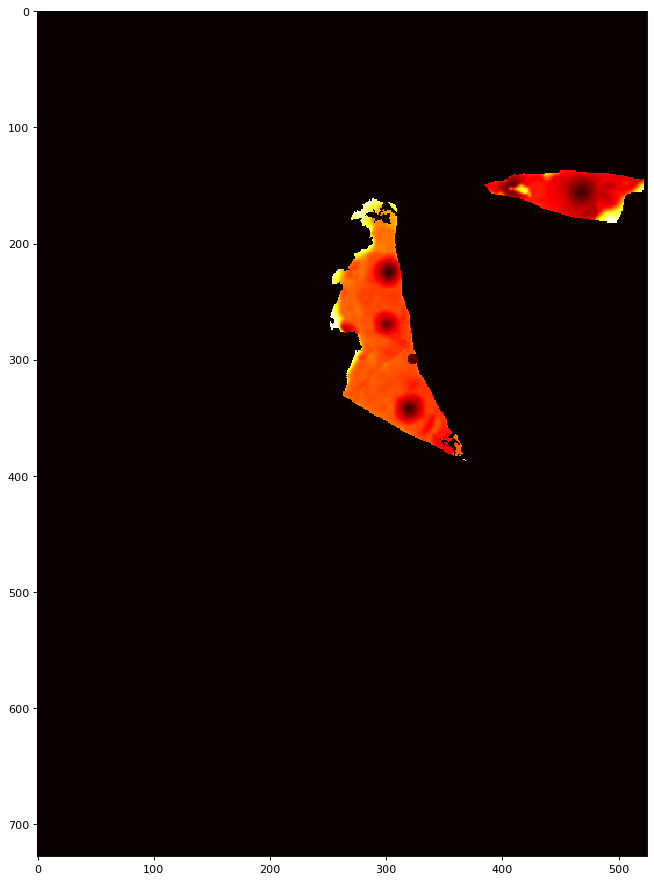

In [50]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(s_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

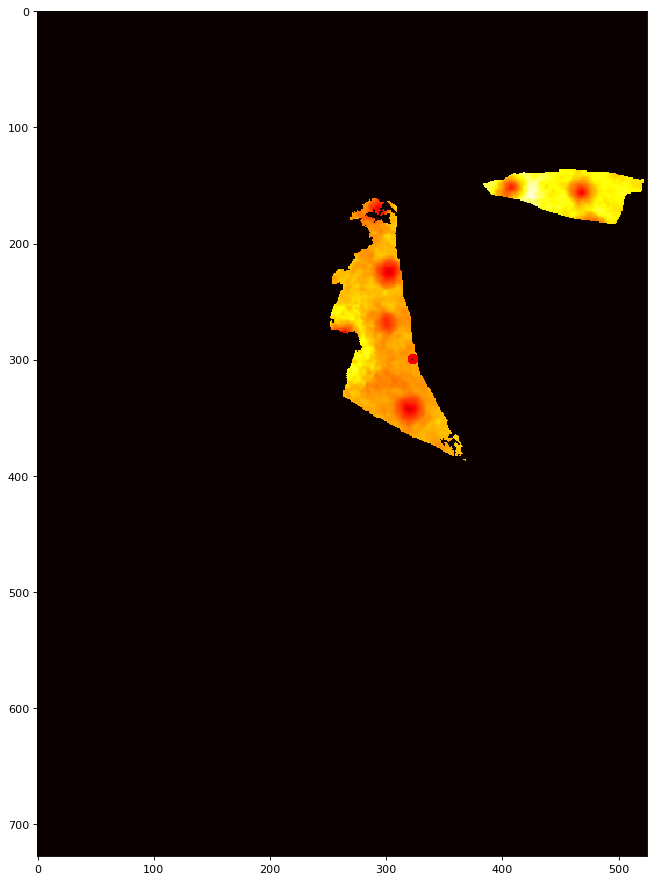

In [51]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(p_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

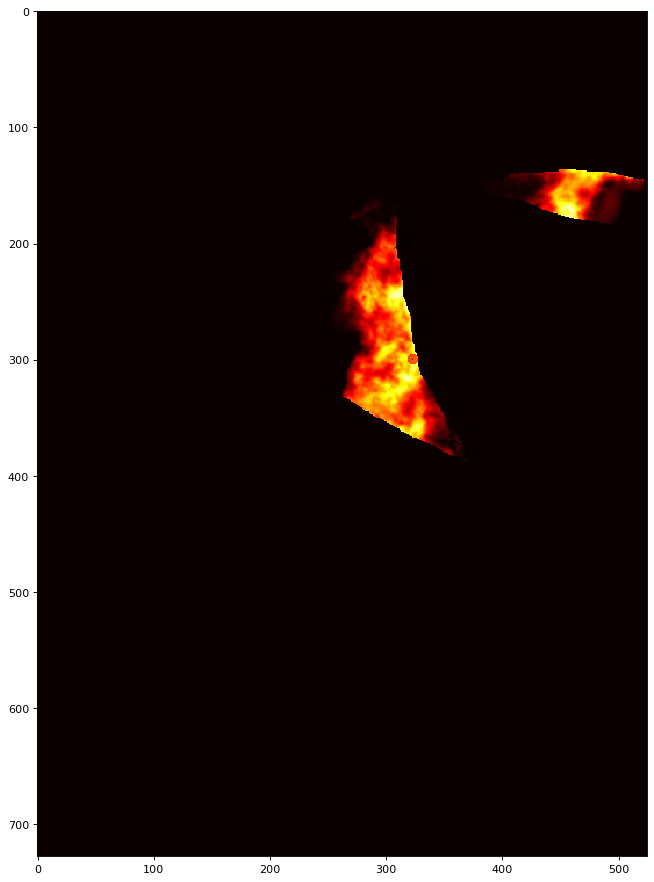

In [52]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(d_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

In [54]:
files = ['non_zero_Saturation delta', 'non_zero_Porosity delta', 'non_zer_Depth delta']
i = 0
for optimized_grid_values in [s_optimized_grid_values, p_optimized_grid_values, d_optimized_grid_values]:
    optimized_grid_values = np.fliplr(optimized_grid_values[::-1,::-1])
    p_lines = []
    p_lines.append(lines[0])
    p_lines.append(lines[1])
    p_lines.append(lines[2])
    p_lines.append(lines[3])

    s = ''
    b = 0
    for v in tqdm(optimized_grid_values):
        for x in v:
            b += 1
            if x == 0.0:
                x = 9999900.000000
            s += str(x)
            if b >= 6:
                b = 0
                p_lines.append(s)
                s = ''
            else:
                s += ' '
    print(len(p_lines) == len(lines))
    
    filename = files[i]
    
    print('Saving', filename, '...')
    with open(filename, 'a') as f:
        for l in p_lines:
            f.write(l+'\n')
            
    i += 1

100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 2766.85it/s]


True
Saving non_zero_Saturation delta ...


100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 2768.08it/s]


True
Saving non_zero_Porosity delta ...


100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 2799.88it/s]


True
Saving non_zer_Depth delta ...


### Nelder-mead algorithm

In [33]:
x = np.arange(0, numX)
y = np.arange(0, numY)

In [34]:
s_min_std = 1
p_min_std = 1
d_min_std = 1

s_well_coords = (0, 0)
p_well_coords = (0, 0)
d_well_coords = (0, 0)

s_optimized_grid_values = s_grid_values
p_optimized_grid_values = p_grid_values
d_optimized_grid_values = d_grid_values

for i in tqdm(range(0, len(s_grid_values))):
    for j in range(0, len(s_grid_values[i])):
        if s_grid_values[i][j] == 0.0 and p_grid_values[i][j] == 0.0 and d_grid_values[i][j] == 0.0:
            continue
        
        c_s_grid_values = s_grid_values.copy()
        c_p_grid_values = p_grid_values.copy()
        c_d_grid_values = d_grid_values.copy()
        
        cx = float(j)
        cy = float(i)
        mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        
        sigmoid_rad = []
        for b in c_s_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_s_grid_values[mask] = sigmoid_rad
        c_s_grid_values[j][i] = 0.001
        
        sigmoid_rad = []
        for b in c_p_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_p_grid_values[mask] = sigmoid_rad
        c_p_grid_values[j][i] = 0.001
        
        sigmoid_rad = []
        for b in c_d_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_d_grid_values[mask] = sigmoid_rad
        c_d_grid_values[j][i] = 0.001
                
        plast_sum = np.sum(c_s_grid_values) / np.sum(s_grid_values)
        if s_min_std > plast_sum:
            s_optimized_grid_values = c_s_grid_values.copy()
            s_well_coords = (i, j)
            s_min_std = plast_sum
            
        plast_sum = np.sum(c_p_grid_values) / np.sum(p_grid_values)
        if p_min_std > plast_sum:
            p_optimized_grid_values = c_p_grid_values.copy()
            p_well_coords = (i, j)
            p_min_std = plast_sum
            
        plast_sum = np.sum(c_d_grid_values) / np.sum(d_grid_values)
        if d_min_std > plast_sum:
            d_optimized_grid_values = c_d_grid_values.copy()
            d_well_coords = (i, j)
            d_min_std = plast_sum

100%|████████████████████████████████████████████████████████████████████████████████| 728/728 [01:58<00:00,  6.13it/s]


In [35]:
x = min(s_well_coords[0], p_well_coords[0], d_well_coords[0])
y = min(s_well_coords[1], p_well_coords[1], d_well_coords[1])
result = minimize(objective, [x, y], method='nelder-mead')

In [36]:
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 76
Solution: f([269.85 248.9 ]) = 0.00000


In [37]:
well_coords = (int(solution[0]), int(solution[1]))

In [38]:
x = np.arange(0, numX)
y = np.arange(0, numY)

In [39]:
c_s_grid_values = s_grid_values.copy()
c_p_grid_values = p_grid_values.copy()
c_d_grid_values = d_grid_values.copy()
        
cx = float(well_coords[1])
cy = float(well_coords[0])
j, i = well_coords[0], well_coords[1]
mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        
sigmoid_rad = []
for b in c_s_grid_values[mask]:
    sigmoid_rad.append(math.atan(b))
c_s_grid_values[mask] = sigmoid_rad
c_s_grid_values[j][i] = 0.001

sigmoid_rad = []
for b in c_p_grid_values[mask]:
    sigmoid_rad.append(math.atan(b))
c_p_grid_values[mask] = sigmoid_rad
c_p_grid_values[j][i] = 0.001
        
sigmoid_rad = []
for b in c_d_grid_values[mask]:
    sigmoid_rad.append(math.atan(b))
c_d_grid_values[mask] = sigmoid_rad
c_d_grid_values[j][i] = 0.001

s_optimized_grid_values = c_s_grid_values.copy()
p_optimized_grid_values = c_p_grid_values.copy()
d_optimized_grid_values = c_d_grid_values.copy()
s_well_coords = (cx, cy)
s_min_std = plast_sum

In [40]:
print('OPTIMIZED')
print('d_saturation:', np.sum(s_grid_values) - np.sum(s_optimized_grid_values))
print('d_porosity:', np.sum(p_grid_values) - np.sum(p_optimized_grid_values))
print('d_depth:', np.sum(d_grid_values) - np.sum(d_optimized_grid_values))
print('d_all:', np.sum(s_grid_values) + np.sum(p_grid_values) + np.sum(d_grid_values) - np.sum(s_optimized_grid_values) - np.sum(p_optimized_grid_values) - np.sum(d_optimized_grid_values))
print('%saturation:', (1-(np.sum(s_optimized_grid_values) / np.sum(s_grid_values)))*100)
print('%porosity:', (1-(np.sum(p_optimized_grid_values) / np.sum(p_grid_values)))*100)
print('%depth:', (1-(np.sum(d_optimized_grid_values) / np.sum(d_grid_values)))*100)
print('%all:', (1 - (np.sum(s_optimized_grid_values) + np.sum(p_optimized_grid_values) + np.sum(d_optimized_grid_values)) / (np.sum(s_grid_values) + np.sum(p_grid_values) + np.sum(d_grid_values)))*100)

OPTIMIZED
d_saturation: 331.3189180510235
d_porosity: 64.83519545887248
d_depth: 2.798743869516329
d_all: 398.95285737940503
%saturation: 0.4322940969798683
%porosity: 0.22742106614815905
%depth: 0.02316942500414365
%all: 0.340315285723336


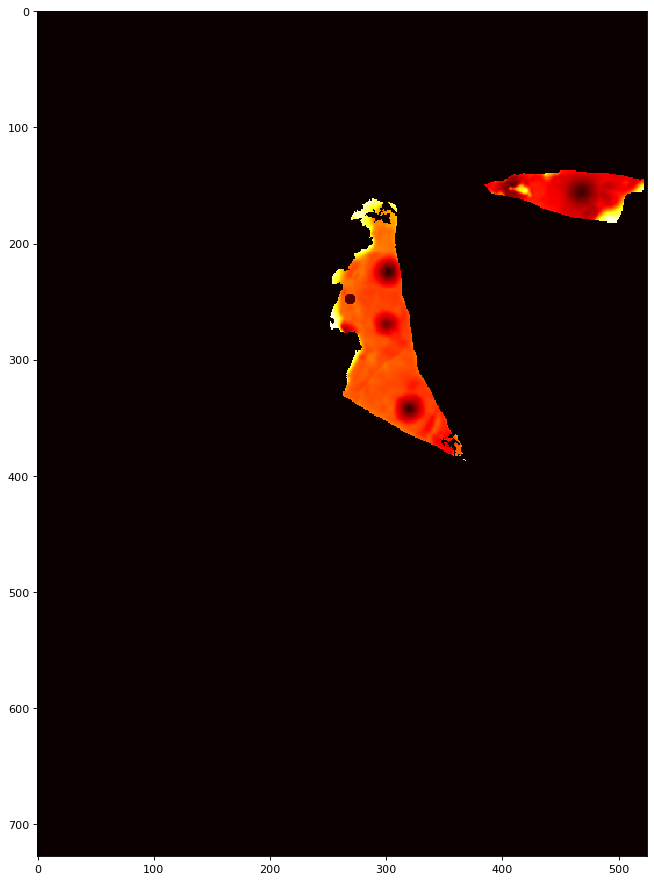

In [41]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(s_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

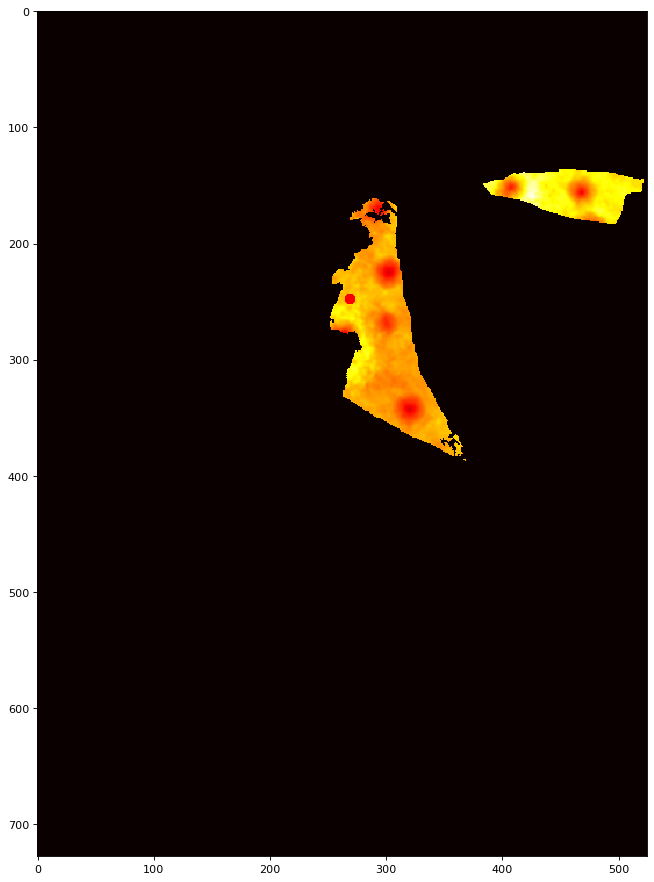

In [42]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(p_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

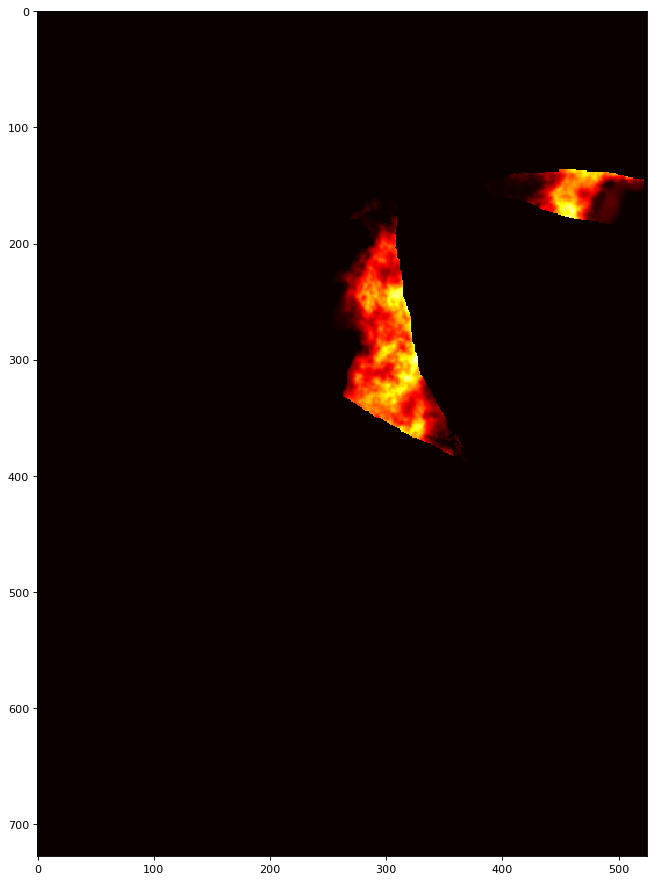

In [43]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(d_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

In [44]:
files = ['non_zero_Saturation nelder-mead', 'non_zero_Porosity nelder-mead', 'non_zero_Depth nelder-mead']
i = 0
for optimized_grid_values in [s_optimized_grid_values, p_optimized_grid_values, d_optimized_grid_values]:
    optimized_grid_values = np.fliplr(optimized_grid_values[::-1,::-1])
    p_lines = []
    p_lines.append(lines[0])
    p_lines.append(lines[1])
    p_lines.append(lines[2])
    p_lines.append(lines[3])

    s = ''
    b = 0
    for v in tqdm(optimized_grid_values):
        for x in v:
            b += 1
            if x == 0.0:
                x = 9999900.000000
            s += str(x)
            if b >= 6:
                b = 0
                p_lines.append(s)
                s = ''
            else:
                s += ' '
    print(len(p_lines) == len(lines))
    
    filename = files[i]
    
    print('Saving', filename, '...')
    with open(filename, 'a') as f:
        for l in p_lines:
            f.write(l+'\n')
            
    i += 1

100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 3046.03it/s]


True
Saving non_zero_Saturation nelder-mead ...


100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 3090.81it/s]


True
Saving non_zero_Porosity nelder-mead ...


100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 3084.77it/s]

True
Saving non_zero_Depth nelder-mead ...
